## Question 2

In [202]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
warnings.filterwarnings('ignore')


[[ 1.76405235  0.40015721]
 [ 0.97873798  2.2408932 ]
 [ 1.86755799 -0.97727788]
 [ 0.95008842 -0.15135721]
 [-0.10321885  0.4105985 ]
 [ 0.14404357  1.45427351]
 [ 0.76103773  0.12167502]
 [ 0.44386323  0.33367433]
 [ 1.49407907 -0.20515826]
 [ 0.3130677  -0.85409574]]
[1 1 0 0 0 1 1 1 0 0]


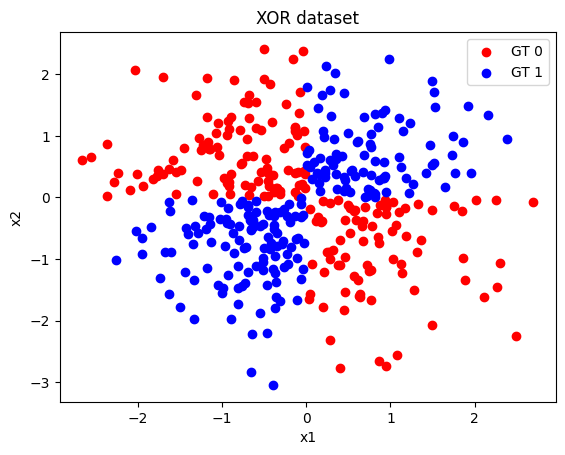

In [203]:
# Generating XOR dataset
np.random.seed(0)
X = np.random.randn(400, 2) # 400 random points in 2D (x1, x2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] < 0).astype(int) # XOR function giving ground truth (y)

# Printing some values for verification
print(X[0:10])
print(y[0:10])

# Plotting the graph
plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', marker='o', label='GT 0')
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', marker='o', label='GT 1')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.title('XOR dataset')
plt.show()

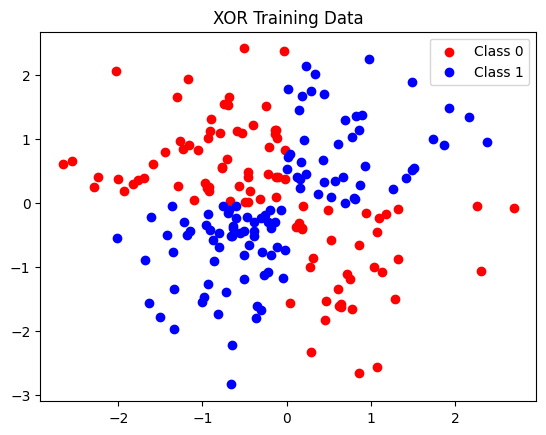

In [204]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

# Plotting the XOR data
plt.scatter(X_train[y_train == 0][:, 0], X_train[y_train == 0][:, 1], color='red', label='Class 0')
plt.scatter(X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1], color='blue', label='Class 1')
plt.title('XOR Training Data')
plt.legend()
plt.show()

In [205]:
# Converting to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)

In [206]:
# Function to plot the decision boundary
def plot_decision_boundary(model, X, y):
    y = y.ravel()     # Reshaping y to be 1D

    # Defining the mesh grid boundaries
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1 # Adding and subtracting 1 to give some space around the data points
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1)) # Creating mesh grid points for contour plot (0.1 is the step size)
    
    # Generating grid points and predicting the class
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32) # Converting to tensor and reshaping to 2D
    Z = model(grid)
    Z = Z.detach().numpy().reshape(xx.shape) # Detaching from the computational graph and reshaping to 2D array for contour plot

    # Plotting the contour (decision boundary)
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdBu)
    # Plotting the data points
    plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='red', label='Class 0', edgecolor='k')
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', label='Class 1', edgecolor='k')
    plt.title("XOR Decision Boundary")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend(loc='best')
    plt.show()

#### a. MLP with 2 hidden layers (8 neurons each)

Epoch 0:- Loss: 0.7165
Epoch 10:- Loss: 0.6911
Epoch 20:- Loss: 0.6537
Epoch 30:- Loss: 0.5807
Epoch 40:- Loss: 0.4714
Epoch 50:- Loss: 0.3520
Epoch 60:- Loss: 0.2551
Epoch 70:- Loss: 0.1878
Epoch 80:- Loss: 0.1453
Epoch 90:- Loss: 0.1186


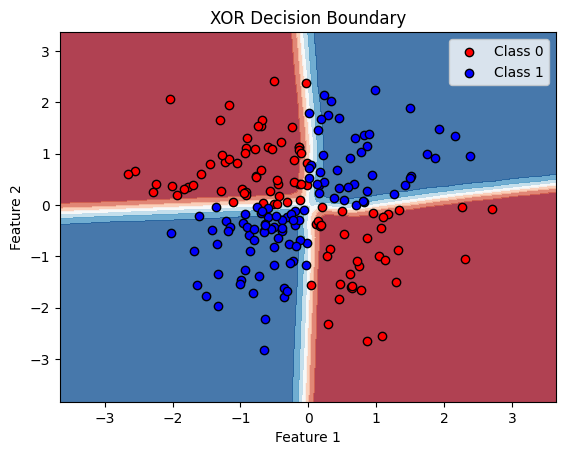

In [207]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(2, 8) # 2 input features, 8 hidden units
        self.layer2 = nn.Linear(8, 8) # 8 hidden units, 8 hidden units
        self.layer3 = nn.Linear(8, 1) # 8 hidden units, 1 output unit

    def forward(self, x):
        x = torch.relu(self.layer1(x)) # ReLU activation for hidden layers
        x = torch.relu(self.layer2(x)) 
        x = torch.sigmoid(self.layer3(x)) # Sigmoid activation for output layer
        return x
    
model = MLP()
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 100
for epoch in range(epochs):
    # Forward pass
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Printing loss every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch}:- Loss: {loss.item():.4f}')

plot_decision_boundary(model, X_train.numpy(), y_train.numpy())

In [208]:
#Accuracy for MLP
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1) # Reshaping to 2D tensor
y_pred = model(X_test)
y_pred = y_pred > 0.5 # Converting to binary predictions 
accuracy = (y_pred == y_test).sum().item() / y_test.size(0) * 100
print(f'Accuracy: {accuracy:.2f}%')

Accuracy: 98.50%


In [209]:
# Function to train the model and evaluate validation loss
def train_with_validation(model, X_train, y_train, X_val, y_val, lambd, pen, epochs=200):
    criterion = nn.BCELoss()  # Binary Cross Entropy Loss
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    best_val_loss = float('inf')
    for epoch in range(epochs):
        # Forward pass for training
        model.train()
        y_pred_train = model(X_train)
        # Adding L1 or L2 regularization loss
        if pen==1:
            loss_train = criterion(y_pred_train, y_train) + model.l1_loss(lambd)
        elif pen==2:
            loss_train = criterion(y_pred_train, y_train) + model.l2_loss(lambd)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        # Validation step
        model.eval()
        with torch.no_grad():
            y_pred_val = model(X_val)
            if pen==1:
                loss_val = criterion(y_pred_val, y_val) + model.l1_loss(lambd)
            elif pen==2:
                loss_val = criterion(y_pred_val, y_val) + model.l2_loss(lambd)

        # Track the best validation loss
        if loss_val.item() < best_val_loss:
            best_val_loss = loss_val.item()

        # Print losses every 50 epochs
        if epoch % 50 == 0:
            print(f'Epoch {epoch}, Train Loss: {loss_train.item():.4f}, Val Loss: {loss_val.item():.4f}')
    
    return best_val_loss


#### b. MLP w/ L1 Regularization


Training with lambda = 0.0001
Epoch 0, Train Loss: 0.7209, Val Loss: 0.6969
Epoch 50, Train Loss: 0.3803, Val Loss: 0.4555
Epoch 100, Train Loss: 0.1149, Val Loss: 0.1355
Epoch 150, Train Loss: 0.0579, Val Loss: 0.1223

Training with lambda = 0.001
Epoch 0, Train Loss: 0.7266, Val Loss: 0.7106
Epoch 50, Train Loss: 0.3707, Val Loss: 0.4372
Epoch 100, Train Loss: 0.1292, Val Loss: 0.1895
Epoch 150, Train Loss: 0.1035, Val Loss: 0.2049

Training with lambda = 0.01
Epoch 0, Train Loss: 0.8695, Val Loss: 0.8600
Epoch 50, Train Loss: 0.6969, Val Loss: 0.7094
Epoch 100, Train Loss: 0.6913, Val Loss: 0.7051
Epoch 150, Train Loss: 0.6912, Val Loss: 0.7051

Training with lambda = 0.1
Epoch 0, Train Loss: 2.5358, Val Loss: 2.4509
Epoch 50, Train Loss: 0.7823, Val Loss: 0.7912
Epoch 100, Train Loss: 0.7025, Val Loss: 0.7163
Epoch 150, Train Loss: 0.6995, Val Loss: 0.7149

Best lambda: 0.0001, with validation loss: 0.1053

Retraining the model with the best lambda (0.0001)...
Epoch 0, Train Loss:

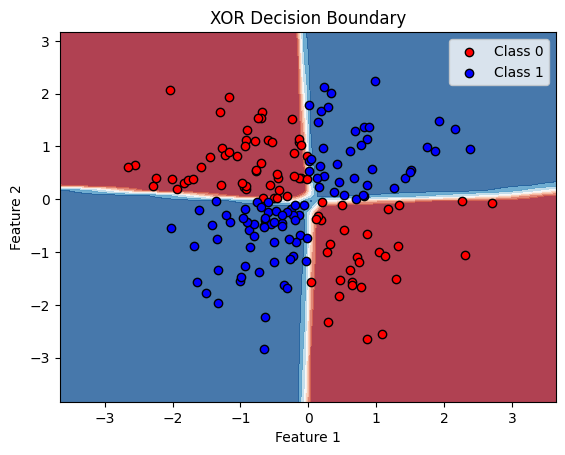

In [210]:
# L1 Regularization
class MLP_L1(nn.Module):
    def __init__(self):
        super(MLP_L1, self).__init__()
        self.layer1 = nn.Linear(2, 8)
        self.layer2 = nn.Linear(8, 8)
        self.layer3 = nn.Linear(8, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.sigmoid(self.layer3(x))
        return x
    
    def l1_loss(self, lambd):
        l1_reg = torch.tensor(0., device=self.layer1.weight.device)
        for name, param in self.named_parameters():
            if 'weight' in name:
                l1_reg += torch.norm(param, 1) # L1 norm of the weights
        return lambd * l1_reg

# Searching for the best L1 penalty
lambd_values = [0.0001, 0.001, 0.01, 0.1]
best_lambd = None
best_val_loss = float('inf') # Initializing with a large value
X_val, X_train, y_val, y_train = train_test_split(X_train, y_train, test_size=0.9) # Splitting the training data into training and validation sets

for lambd in lambd_values:
    print(f"\nTraining with lambda = {lambd}")
    model_l1 = MLP_L1()
    val_loss = train_with_validation(model_l1, X_train, y_train, X_val, y_val, lambd, 1) # L1 penalty
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_lambd = lambd

print(f"\nBest lambda: {best_lambd}, with validation loss: {best_val_loss:.4f}")

# Retraining the final model using the best lambda
print(f"\nRetraining the model with the best lambda ({best_lambd})...")

model_l1_final = MLP_L1()
train_with_validation(model_l1_final, X_train, y_train, X_test, y_test, best_lambd, pen=1)

plot_decision_boundary(model_l1_final, X_train.numpy(), y_train.numpy())


In [211]:
# Accuracy for L1 Regularization
y_pred = model_l1_final(X_test)
y_pred = y_pred > 0.5
accuracy = (y_pred == y_test).sum().item() / y_test.size(0) * 100
print(f'Accuracy: {accuracy:.2f}%')


Accuracy: 98.50%


#### c. MLP w/ L2 Regularization


Training with lambda = 0.0001
Epoch 0, Train Loss: 0.7030, Val Loss: 0.6895
Epoch 50, Train Loss: 0.2136, Val Loss: 0.2299
Epoch 100, Train Loss: 0.0658, Val Loss: 0.1175
Epoch 150, Train Loss: 0.0399, Val Loss: 0.1098

Training with lambda = 0.001
Epoch 0, Train Loss: 0.7493, Val Loss: 0.7572
Epoch 50, Train Loss: 0.5031, Val Loss: 0.4315
Epoch 100, Train Loss: 0.1113, Val Loss: 0.1553
Epoch 150, Train Loss: 0.0603, Val Loss: 0.1464

Training with lambda = 0.01
Epoch 0, Train Loss: 0.7270, Val Loss: 0.7144
Epoch 50, Train Loss: 0.3981, Val Loss: 0.3442
Epoch 100, Train Loss: 0.1874, Val Loss: 0.2979
Epoch 150, Train Loss: 0.1722, Val Loss: 0.3330

Training with lambda = 0.1
Epoch 0, Train Loss: 1.0652, Val Loss: 1.0543
Epoch 50, Train Loss: 0.7224, Val Loss: 0.7171
Epoch 100, Train Loss: 0.6918, Val Loss: 0.6892
Epoch 150, Train Loss: 0.6912, Val Loss: 0.6884

Best lambda: 0.0001, with validation loss: 0.1053

Retraining the model with the best lambda (0.0001)...
Epoch 0, Train Loss:

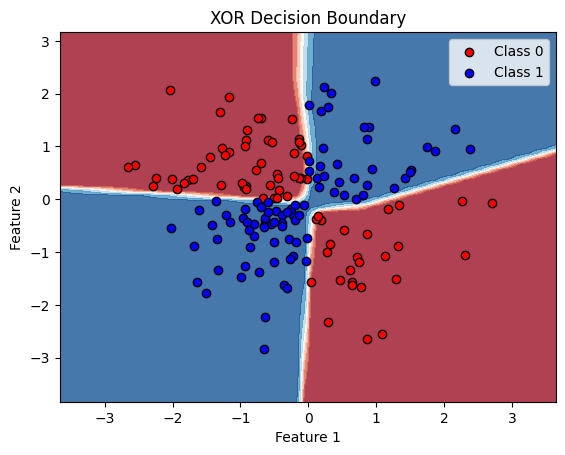

In [212]:
# L2 regularization

class MLP_L2(nn.Module):
    def __init__(self):
        super(MLP_L2, self).__init__()
        self.layer1 = nn.Linear(2, 8)
        self.layer2 = nn.Linear(8, 8)
        self.layer3 = nn.Linear(8, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.sigmoid(self.layer3(x))
        return x
    
    def l2_loss(self, lambd):
        l2_reg = torch.tensor(0., device=self.layer1.weight.device)
        for name, param in self.named_parameters():
            if 'weight' in name:
                l2_reg += torch.norm(param, 2) # L2 norm of the weights
        return lambd * l2_reg
    
model_l2 = MLP_L2()
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
optimizer = optim.Adam(model_l2.parameters(), lr=0.01)
X_val, X_train, y_val, y_train = train_test_split(X_train, y_train, test_size=0.9) # Splitting the training data into training and validation sets

for lambd in lambd_values:
    print(f"\nTraining with lambda = {lambd}")
    model_l2 = MLP_L2()
    val_loss = train_with_validation(model_l2, X_train, y_train, X_val, y_val, lambd, 2) # L2 penalty
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_lambd = lambd

print(f"\nBest lambda: {best_lambd}, with validation loss: {best_val_loss:.4f}")

# Retraining the final model using the best lambda
print(f"\nRetraining the model with the best lambda ({best_lambd})...")

model_l2_final = MLP_L2()
train_with_validation(model_l2_final, X_train, y_train, X_test, y_test, best_lambd, 2)

plot_decision_boundary(model_l2_final, X_train.numpy(), y_train.numpy())

In [213]:
# Accuracy for L2 Regularization
y_pred = model_l2_final(X_test)
y_pred = y_pred > 0.5
accuracy = (y_pred == y_test).sum().item() / y_test.size(0) * 100
print(f'Accuracy: {accuracy:.2f}%')

Accuracy: 96.00%


#### d. Logistic regression

Epoch 0, Loss: 0.6570
Epoch 50, Loss: 0.5101
Epoch 100, Loss: 0.4450
Epoch 150, Loss: 0.4024
Epoch 200, Loss: 0.3719
Epoch 250, Loss: 0.3485
Epoch 300, Loss: 0.3298
Epoch 350, Loss: 0.3143
Epoch 400, Loss: 0.3012
Epoch 450, Loss: 0.2899
Epoch 500, Loss: 0.2799
Epoch 550, Loss: 0.2711
Epoch 600, Loss: 0.2632
Epoch 650, Loss: 0.2560
Epoch 700, Loss: 0.2495
Epoch 750, Loss: 0.2434
Epoch 800, Loss: 0.2379
Epoch 850, Loss: 0.2327
Epoch 900, Loss: 0.2279
Epoch 950, Loss: 0.2234


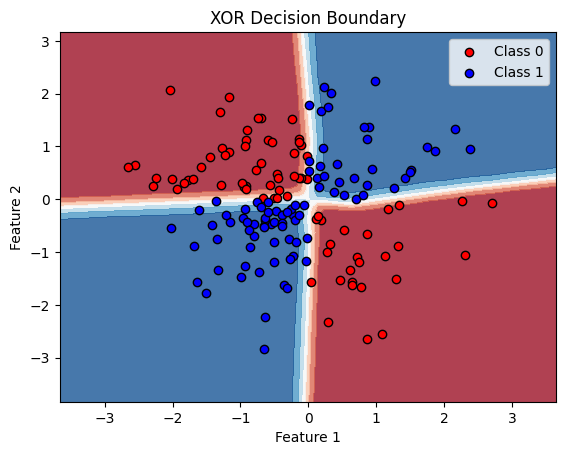

In [214]:
# Logistic regression

class MLP2(nn.Module):
    def __init__(self):
        super(MLP2, self).__init__()
        self.layer1 = nn.Linear(5, 1) # 5 input features, 1 output unit (Logistic Regression)

    def forward(self, x):
        x = torch.sigmoid(self.layer1(x))
        return x
    
model2 = MLP2()
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
optimizer = optim.Adam(model2.parameters(), lr=0.01)

X_train_log = torch.tensor(X_train, dtype=torch.float32)  # Ensuring X_train is a tensor

# Creating new features x1^2, x2^2, and x1*x2 for training data
x1 = X_train_log[:, 0].reshape(-1, 1)
x2 = X_train_log[:, 1].reshape(-1, 1)
x1_square = x1 ** 2
x2_square = x2 ** 2
x1_x2 = x1 * x2

# Concatenating the original features with the new ones
X_train_augmented = torch.cat([X_train_log, x1_square, x2_square, x1_x2], dim=1)

epochs = 1000
for epoch in range(epochs):
    # Forward pass
    y_pred = model2(X_train_augmented)
    loss = criterion(y_pred, y_train)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Printing loss every 50 epochs
    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

plot_decision_boundary(model, X_train_augmented.numpy(), y_train.numpy())

In [215]:
# Accuracy for Logistic Regression

X_test_log = torch.tensor(X_test, dtype=torch.float32)  # Converting X_test to tensor

# Creating new features x1^2, x2^2, and x1*x2 for test data
x1 = X_test_log[:, 0].reshape(-1, 1)
x2 = X_test_log[:, 1].reshape(-1, 1)
x1_square = x1 ** 2
x2_square = x2 ** 2
x1_x2 = x1 * x2

# Concatenating the original features with the new ones for test data
X_test_augmented = torch.cat([X_test_log, x1_square, x2_square, x1_x2], dim=1)

y_pred = model2(X_test_augmented)
y_pred = y_pred > 0.5 
accuracy = (y_pred == y_test).sum().item() / y_test.size(0) * 100
print(f'Accuracy: {accuracy:.2f}%')

Accuracy: 92.00%


#### Comments on the different models

- The accuracy for the models is of the order:
    MLP>L1>L2>Logistic

- Logistic model is a single mlp